# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.

In [3]:
# Get some more content of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   article_id  45993 non-null  float64
 1   title       45993 non-null  object 
 2   email       45976 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [4]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_body         1042 non-null   object
 1   doc_description  1053 non-null   object
 2   doc_full_name    1056 non-null   object
 3   doc_status       1056 non-null   object
 4   article_id       1056 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 41.4+ KB


Some data of `email` in the `df` dataframe appears to be missing. Same applies to `doc_body` and `doc_description` in `df_content`. `article_id` seems to be the key field between the two tables, where `df` is the data table and `df_content` probably the lookup table.

In [5]:
# Check missing emails in df
df[df['email'].isnull()]

,article_id,title,email
25131,1016.0,why you should master r (even if it might even...,NaN
29758,1393.0,the nurse assignment problem,NaN
29759,20.0,working interactively with rstudio and noteboo...,NaN
29760,1174.0,breast cancer wisconsin (diagnostic) data set,NaN
29761,62.0,data visualization: the importance of excludin...,NaN
35264,224.0,"using apply, sapply, lapply in r",NaN
35276,961.0,beyond parallelize and collect,NaN
35277,268.0,sector correlations shiny app,NaN
35278,268.0,sector correlations shiny app,NaN
35279,268.0,sector correlations shiny app,NaN


In [6]:
# Check missing doc_body in df_content
df_content[df_content['doc_body'].isnull()]

,doc_body,doc_description,doc_full_name,doc_status,article_id
206,NaN,Watch how to convert XML data to CSV format to...,Load XML data into dashDB,Live,206
276,NaN,Love to work in Microsoft Excel? Watch how to ...,Integrate dashDB with Excel,Live,276
484,NaN,See how to evaluate and convert your DDL and S...,Convert IBM Puredata for Analytics to dashDB,Live,483
508,NaN,Watch how to generate SQL-based reports for Cl...,Use dashDB with IBM Embeddable Reporting Service,Live,507
540,NaN,Need to move some data to the cloud for wareho...,Convert data from Oracle to dashDB,Live,539
638,NaN,See how to create a new dashDB instance and po...,Load JSON from Cloudant database into dashDB,Live,637
667,NaN,"See how to connect dashDB, as a source and tar...",Integrate dashDB and Informatica Cloud,Live,666
706,NaN,Aginity Workbench is a free application known ...,Use Aginity Workbench for IBM dashDB,Live,704
842,NaN,Learn how to configure a dashDB connection in ...,Leverage dashDB in Cognos Business Intelligence,Live,839
876,NaN,See how to populate data into a table in your ...,Load data from the desktop into dashDB,Live,873


In [7]:
# Check missing doc_body in df_content
df_content[df_content['doc_description'].isnull()]

,doc_body,doc_description,doc_full_name,doc_status,article_id
354,The search index lets you create flexible quer...,NaN,Build the search index in Cloudant,Live,354
768,Compose The Compose logo Articles Sign in Free...,NaN,Announcing the Data Browser for JanusGraph,Live,765
919,Cloudant Query is a powerful declarative JSON ...,NaN,Use the new Cloudant query,Live,916


**During the exploratory data analysis it needs to be evaluated if and how to deal with these missing values.**

In [8]:
# How many unique article IDs are in df?
df.article_id.nunique()

714

In [9]:
# Are there duplicate article_ids in df_content?
df_content.article_id.nunique()

1051

In [10]:
df_content.article_id.value_counts().head(10)

221    2
232    2
577    2
398    2
50     2
356    1
355    1
354    1
353    1
345    1
Name: article_id, dtype: int64

**5 articles are duplicated. It must be assumed that the article_id must be a unique identifier. Trying to delete if "completely" duplicates:**

In [11]:
df_content.drop_duplicates(inplace=True)
df_content.article_id.value_counts().head(10)

221    2
232    2
577    2
398    2
50     2
356    1
355    1
354    1
353    1
345    1
Name: article_id, dtype: int64

**This didn't help. Apparently, there is some difference. Check what articles these are:**

In [12]:
df_content[(df_content.article_id.isin([
    221,
    232,
    577,
    398,
    50
]))].sort_values('article_id')

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [13]:
# These article_ids were used in df?
df[(df.article_id.isin([
    221,
    232,
    577,
    398,
    50
]))].groupby('article_id').count()

,title,email
article_id,,
50.0,89,89
221.0,113,113
232.0,68,68
398.0,21,21


In [14]:
# We need to remove the duplicates in df_content
#Because we don't known which record is correct we simply keep the first record. This is OK because of the small amount.
df_content = df_content.groupby('article_id').first().reset_index()

In [15]:
df_content[(df_content.article_id.isin([
    221,
    232,
    577,
    398,
    50
]))].sort_values('article_id')

,article_id,doc_body,doc_description,doc_full_name,doc_status
50,50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live
221,221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live
232,232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live
398,398,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live
577,577,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live


Duplicates removed.

---
### User interactions
How many interactions are done by users?
I assume that a user is represented by an email and is not using two different email adressed.

<AxesSubplot:ylabel='Frequency'>

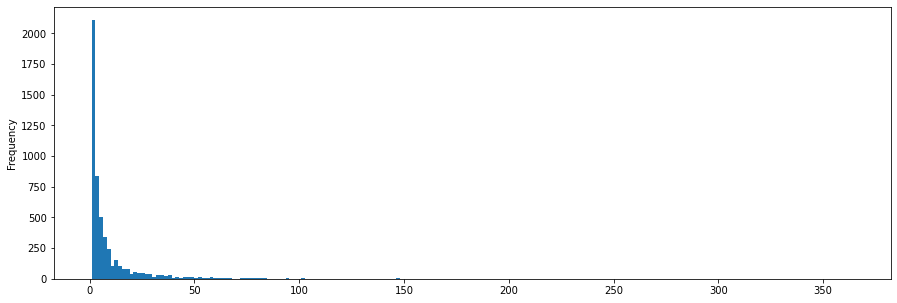

In [16]:
df['email'].value_counts().plot(kind='hist', figsize=(15,5), bins=200)

<AxesSubplot:>

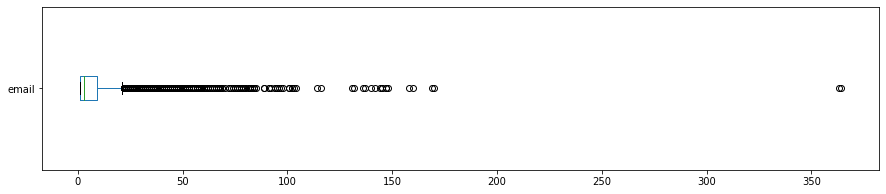

In [17]:
df['email'].value_counts().plot(kind='box', vert=False, figsize=(15,3))

In [18]:
df['email'].value_counts().mean()

8.930846930846931

<AxesSubplot:ylabel='Frequency'>

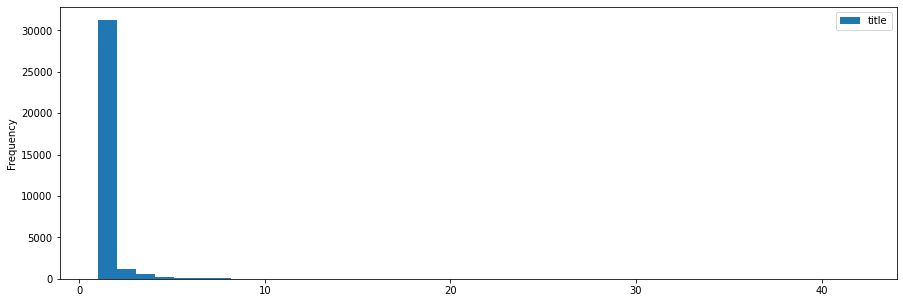

In [19]:
# Histogram of the user interaction with distinct articles
df.groupby([
    'email',
    'article_id'
]).count().sort_values(
    'title',
    ascending=False
).plot(
    kind='hist',
    figsize=(15,5),
    bins=40
)

<AxesSubplot:>

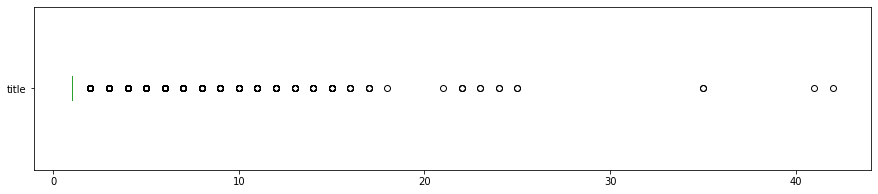

In [20]:
df.groupby([
    'email',
    'article_id'
]).count().sort_values(
    'title',
    ascending=False
).plot(
    kind='box',
    vert=False,
    figsize=(15,3)
)

In [21]:
#Average interation of a user with a distict article
df.groupby(['email','article_id']).count().mean()

title    1.365529
dtype: float64

A user interacts with a distinct article in average 1.37 times. The disctribution showa that the big mojority of users only interact on time with an article. There are a few outliers where users interact over 40 times.

In [22]:
# Fill in the median and maximum number of user_article interactios below

median_val = df.groupby(['email']).count().median()[0] # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = df.groupby(['email']).count().max()[0] # The maximum number of user-article interactions by any 1 user is ______.

In [23]:
# Median interactions
median_val

3.0

In [24]:
# Maximum interactions
max_views_by_user

364

`2.` Explore and remove duplicate articles from the **df_content** dataframe.

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [25]:
len(df)

45993

In [26]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051  # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [27]:
# Top 10 articles, sorted by interactions
df.groupby('article_id').count().sort_values('email', ascending=False).head()

,title,email
article_id,,
1429.0,937,937
1330.0,927,927
1431.0,671,671
1427.0,643,643
1364.0,627,627


In [28]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [29]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [30]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank Based Recommendations</a>

Unlike in the earlier lessons, we do not actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [33]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    top_ids = get_top_article_ids(n, df)
    
    top_articles = []
    
    for i in top_ids:
        top_articles.append(df[df['article_id'] == float(i)].groupby('title').first().index[0])
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.groupby('article_id').count().sort_values('title', ascending=False).head(n).index.values
    
    top_articles = [str(x) for x in top_articles]
 
    return top_articles # Return the top article ids

In [34]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [36]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [37]:
# Custom aggregate function for groupby to assign 1 to "hits"
def binomizer(x):
    tot = 0
    for val in x:
        if val.isnumeric:
            tot += 1
    if tot > 0:
        return 1

In [38]:
# create the user-article matrix with 1's and 0's
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.groupby([
        'user_id',
        'article_id'
    ]).agg({'title': binomizer}).unstack().fillna(0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [39]:
# Check
user_item.head()

title                                                          \
article_id 0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0   16.0     
user_id                                                                     
1             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3             0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
4             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                   ...                                                   \
article_id 18.0    ... 1434.0 1435.0 1436.0 1437.0 1439.0 1440.0 1441.0   
user_id            ...                                                    
1             0.0  ...    0.0    0.0    1.0    0.0    1.0    0.0    0.0   
2             0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3             0.0  ...    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
4             0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5             0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                                 
article_id 1442.0 1443.0 1444.0  
user_id                          
1             0.0    0.0    0.0  
2             0.0    0.0    0.0  
3             0.0    0.0    0.0  
4             0.0    0.0    0.0  
5             0.0    0.0    0.0  

[5 rows x 714 columns]

In [40]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [41]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    movies1 = user_item.loc[user_id]
    user_lst = (user_item.index.tolist())
    unique_users = len(user_item)
    
    dist_to_u1 = []
    for u in range(unique_users):
        dist_to_u1.append(np.dot(movies1, user_item.iloc[u]))
        
    df_dists = pd.DataFrame({
        'user_id': user_lst,
        'dist_to_u1': dist_to_u1
    }).sort_values('dist_to_u1', ascending=False).drop(user_id)

    # sort by similarity

    # create list of just the ids
    most_similar_users = df_dists['user_id']
   
    # remove the own user's id
    
    return most_similar_users # return a list of the users in order from most to least similar

In [42]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: 0          1
3932    3933
22        23
3781    3782
202      203
4458    4459
3869    3870
130      131
4200    4201
45        46
Name: user_id, dtype: int64
The 5 most similar users to user 3933 are: 0          1
3932    3933
22        23
3781    3782
202      203
Name: user_id, dtype: int64
The 3 most similar users to user 46 are: 45        46
4200    4201
3781    3782
Name: user_id, dtype: int64


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [43]:
# Creating articles df
df_articles = df_content[['article_id', 'doc_full_name']]
df_articles.rename(columns={'doc_full_name': 'title'}, inplace=True)

# Combining the two tables
df_articles = pd.concat([df_articles, df[['article_id', 'title']]])

# Grouping by ids (making unique list)
df_articles = df_articles.groupby('article_id').first().reset_index()

# The unitversity's test algoriths checks agains an altered text (all letters small)
df_articles['title'] = df_articles['title'].str.lower()

In [44]:
df_articles.head()

,article_id,title
0,0.0,detect malfunctioning iot sensors with streami...
1,1.0,communicating data science: a guide to present...
2,2.0,"this week in data science (april 18, 2017)"
3,3.0,datalayer conference: boost the performance of...
4,4.0,analyze ny restaurant data using spark in dsx


In [45]:
df_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1328 entries, 0 to 1327
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   article_id  1328 non-null   float64
 1   title       1328 non-null   object 
dtypes: float64(1), object(1)
memory usage: 20.9+ KB


Apparently, there were a range of article_ids either in one or the other list, but not in both.

In [46]:
def get_article_names(article_ids, df=df_articles):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Initiating articles_ids list
    article_names = []
    
    # Looping through all articles
    for article in article_ids:
        article_names.append(df[df['article_id']==float(article)]['title'].values[0])
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Initiating article_ids list
    article_ids = []
    
    # Getting all records for user
    u1_df = user_item[user_item.index==user_id]
    
    # Looping through all records and select ids that are flagged with 1
    for x in u1_df.columns:
        if u1_df[x].values==1:
            article_ids.append(str(x[1]))
    
    # Getting article names for the extracted ids
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Initiating empty recs list
    recs = []
    
    # Get list of already seen articles
    seen_ids, seen_arts = get_user_articles(user_id)
    
    # Get similar users
    close_users = find_similar_users(user_id)
    
    # Looping through ids from close users
    for user in close_users:
        close_ids, close_arts = get_user_articles(user)
        if len(recs) == m:
            break
        for _id in close_ids:
            if _id not in seen_ids:
                recs.append(_id)
                if len(recs) == m:
                    break
    
    if len(recs) < m:
        add_art_ids = get_top_article_ids(200)
        for art_id in add_art_ids:
            if art_id not in recs:
                recs.append(art_id)
                if len(recs) == m:
                    break
    
    return recs # return your recommendations for this user_id

In [47]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame']

In [48]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [49]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Initiating dataframe
    neighbors_df = pd.DataFrame(columns=['neighbor_id', 'similarity', 'num_interactions'])
    
    # Loop through users and create dot-product, iteration count and close-neighbor_id
    for user in user_item.index.values:
        if user != user_id:
            neighbor_id_lst = user
            
            # Calculating similarity (dot-product)
            sim_lst = user_item[
                user_item.index == user_id
            ].dot(user_item.loc[user].T).values[0]
            
            # Calculating iteration count
            iter_list = user_item.loc[user].values.sum()
            
            # Adding df entry
            neighbors_df.loc[neighbor_id_lst] = [neighbor_id_lst, sim_lst, iter_list]
    
    # Making sure that data formats are int
    neighbors_df['neighbor_id'] = neighbors_df['neighbor_id'].astype('int')
    neighbors_df['similarity'] = neighbors_df['similarity'].astype('int')
    
    # Sorting by similarity and then number of iterations as per instruction; user_ids then sorted ascending
    # Update: However, there seem to be a misunderstanding in the test algorithm, in which the sortation is:
    # 1) Similarity descending, 2) user_ids ascending and 3) Strangely NO sortation for the iterations
    neighbors_df = neighbors_df.sort_values(by = [
        'similarity',
        'neighbor_id'
    ], ascending = [False, True])
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Initiating empty recs list
    recs = []
    
    # Get list of already seen articles
    seen_ids, seen_arts = get_user_articles(user_id)
    
    # Get similar users
    close_users = find_similar_users(user_id)
    
    df_count_lst = df.groupby('user_id').agg({
        'article_id': 'count'
    }).reset_index().sort_values('user_id', ascending = False)
    
    # Initiating sorted list
    close_users_sorted = []
    
    # Loop through sorted dataframe and build sorted list
    for x in df_count_lst['user_id']:
        if x in close_users:
            close_users_sorted.append(x)
    
    # Looping through ids from close users
    for user in close_users:
        close_ids, close_arts = get_user_articles(user)
        if len(recs) == m:
            break
        for _id in close_ids:
            if _id not in seen_ids:
                recs.append(_id)
                if len(recs) == m:
                    break
    
    if len(recs) < m:
        add_art_ids = get_top_article_ids(200)
        for art_id in add_art_ids:
            if art_id not in recs:
                recs.append(art_id)
                if len(recs) == m:
                    break
                    
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [50]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['34.0', '124.0', '158.0', '164.0', '256.0', '314.0', '316.0', '337.0', '382.0', '444.0']

The top 10 recommendations for user 20 are the following article names:
['top 10 machine learning use cases: part 1', 'python machine learning: scikit-learn tutorial', 'd3heatmap: interactive heat maps', 'learn tensorflow and deep learning together and now!', 'xml2 1.0.0', 'some random weekend reading', 'leverage python, scikit, and text classification for behavioral profiling', 'generalization in deep learning', 'what is text analytics?', 'declarative machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [51]:
### Tests with a dictionary of results
user1_most_sim = get_top_sorted_users(1).iloc[0].neighbor_id # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9].neighbor_id # Find the 10th most similar user to user 131

In [52]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

For new users collaborative filtering is not possible, simply because the dot product would always be 0. This best way with the aabove options would be to suggest the top rated articles.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [54]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10) # Your recommendations here

In [55]:
get_top_article_ids(10)

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [56]:
df.groupby('article_id').count().sort_values('title', ascending=False).head(10)

,title,user_id
article_id,,
1429.0,937,937
1330.0,927,927
1431.0,671,671
1427.0,643,643
1364.0,627,627
1314.0,614,614
1293.0,572,572
1170.0,565,565
1162.0,512,512


In [57]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term. You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**. There is not one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender. Since there is not one right answer for this recommendation tactic, no test functions are provided. Feel free to change the function inputs if you decide you want to try a method that requires more input values. The input values are currently set with one idea in mind that you may use to make content based recommendations. One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project. However, you may choose to take this on as an extra way to show off your skills.

In [58]:
txt = df_content[df_content['article_id']==10]['doc_body']

In [59]:
for word in txt.str.split():
    print(word)

tachment', '=', 'doc.attachments["photo.jpg"]', '{', 'photo', '=', 'UIImage(', 'data:', 'photoAttachment.dataFromAttachmentContent())', '}', 'self.init(name:name,', 'photo:photo,', 'rating:rating,', 'docId:doc.docId)', '}', 'else', '{', 'print("Error', 'initializing', 'meal', 'from', 'document:', '\\(doc)")', 'returnnil', '}', '}', 'That’s', 'it', 'for', 'the', 'model.', 'The', 'Meal', 'class', 'now', 'tracks', 'its', 'underlying', 'document', 'IDand', 'creation', 'time;', 'and', 'it', 'supports', 'convenient', 'initialization', 'directly', 'from', 'ameal', 'document.Since', 'the', 'Meal', 'model', 'initializer', 'has', 'a', 'new', 'docId:', 'String?', 'parameter,', 'you', 'will', 'need', 'to', 'update', 'the', 'one', 'bit', 'of', 'code', 'which', 'initializes', 'Mealobjects,', 'in', 'the', 'Meal', 'view', 'controller.To', 'update', 'the', 'meal', 'view', 'controller', '1.', 'Open', 'MealViewController.swift', '2.', 'In', 'MealViewController.swift', ',', 'find', 'the', 'function', 'pre

**Thoughts:** Can we work with the text, tokenize, count, rank the words and compare the distance between the users?

In [63]:
#def make_content_recs():
#    '''
#    
#    INPUT:
#    
#    OUTPUT:

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [64]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [66]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [67]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [68]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=True) # use the built in to get the three matrices

In [69]:
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

**SVD can handle this operation:** Our matrix is binomial (1/0). In our previous lesson we used ranks as values and NAN if there was no rank value available. SVD can handle "0" as a numerical data format and perform this operation, while it would fail to do the same with a matrix which contains NAN values.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

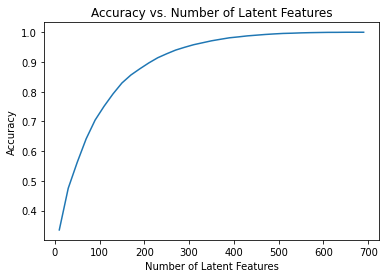

In [70]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [71]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns.levels[1].values
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [72]:
# Refresher
user_item_test.head()

title                                                          \
article_id 0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0   16.0     
user_id                                                                     
2917          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3024          0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
3093          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3193          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3527          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                   ...                                                   \
article_id 18.0    ... 1432.0 1433.0 1434.0 1435.0 1436.0 1437.0 1439.0   
user_id            ...                                                    
2917          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3024          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3093          0.0  ...    0.0    0.0    0.0    0.0    1.0    0.0    0.0   
3193          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3527          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                                 
article_id 1440.0 1441.0 1443.0  
user_id                          
2917          0.0    0.0    0.0  
3024          0.0    0.0    0.0  
3093          0.0    0.0    0.0  
3193          0.0    0.0    0.0  
3527          0.0    0.0    0.0  

[5 rows x 574 columns]

In [73]:
# Refresher
df_test.head()

,article_id,title,user_id
40000,1053.0,access mysql with python,4487
40001,1314.0,healthcare python streaming application demo,4487
40002,1424.0,use spark for python to load data and run sql ...,4487
40003,1176.0,build a python app on the streaming analytics ...,4487
40004,58.0,advancements in the spark community,4488


In [74]:
# Number of users of the test set predictions can be made for
len(np.intersect1d(df_train['user_id'].unique(), df_test['user_id'].unique()))

20

In [75]:
# Number of users of the test set predictions can not be made for (cold start problem)
len(df_test['user_id'].unique()) - len(np.intersect1d(df_train['user_id'].unique(),df_test['user_id'].unique()))

662

In [76]:
# Number of articles of the test set predictions can be made for
len(np.intersect1d(df_test['article_id'].unique(), df_test['article_id'].unique()))

574

In [77]:
# Number of articles of the test set predictions can not be made for (cold start problem)
len(df_test['article_id'].unique()) - len(np.intersect1d(df_train['article_id'].unique(),df_test['article_id'].unique()))

0

In [78]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many movies can we make predictions for in the test set?': b, # letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.
